# Init

In [1]:
import cv2
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import numpy as np
from tkinter import *
from PIL import Image, ImageTk, ImageFont, ImageDraw
from scipy import stats
from skimage import transform
from skimage.io import imread, imshow

# https://towardsdatascience.com/image-processing-with-python-applying-homography-for-image-warping-84cd87d2108f

# wd = 'd:/Katalog 1/Science/Projekt lasery/mikroskop/workbench/'
# sample_img = cv2.imread(wd + 'sample_img.jpg')
# sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

calib_dots_dim = 4
rgb_weights = [0.2989, 0.5870, 0.1140]

In [2]:
def calib_get_postion(comp, sigma = 151):
    # check if it is not outside (no dot)
    if comp.max() < 25:
        return -1
    
    # blur and normalize
    comp = cv2.GaussianBlur(comp, (sigma, sigma), cv2.BORDER_DEFAULT)
    comp = (comp-comp.min())
    comp = comp/comp.max()*255
    
    # threshold, find countor, get center
    tresh = (comp.max()-comp.min())/2
    ret, thresh1 = cv2.threshold(np.uint8(comp), tresh, 1, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    M = cv2.moments(contours[0])
    if M["m00"] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
    else:
        cx = 0
        cy = 0
    
    return [cx, cy]


def num_to_coords(num, size = 10, dim = (1024, 768)):    
    nx = int(num%size)
    ny = int((num-num%size)/size)
    
    inc_x = int(dim[0]/size)
    inc_y = int(dim[1]/size)
    
    x = int(inc_x/2) + nx*inc_x
    y = int(inc_y/2) + ny*inc_y
    
#     print('x = %d, y = %d'%(x, y))
    return x, y


def get_homography_matrix():
    baseline = np.dot(np.load('calibration/baseline.npy')[...,:3], rgb_weights)
    images = []
    for i in range(0, calib_dots_dim**2+1):
        temp = np.load('calibration/num%d.npy'%i)
        images.append(np.dot(temp[...,:3], rgb_weights))
        
    coords_prj = []
    coords_cam = []

    for i in range(0, calib_dots_dim**2+1):
        img = np.load('calibration/num%d.npy'%i)
        img = np.dot(img[...,:3], rgb_weights)
        c = calib_get_postion(img-baseline)
        print(c)
        if c != -1:
            coords_cam.append(c)
            crds = num_to_coords(i, size = calib_dots_dim)
            coords_prj.append([crds[0], crds[1]])
            
    coords_prj_arr = np.array(coords_prj)
    coords_cam_arr = np.array(coords_cam)
    
    h, status = cv2.findHomography(coords_cam_arr, coords_prj_arr)
    im_out = cv2.warpPerspective(baseline, h, (1024, 768))
    
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.set_title('camera image')
    ax1.imshow(baseline, cmap = 'gray')
    for i, crd in enumerate(coords_cam):
        ax1.text(crd[0], crd[1], str(i))
        
    ax2.set_title('projector array')
    ax2.imshow(im_out, cmap = 'gray')
    for i, crd in enumerate(coords_prj):
        ax2.text(crd[0], crd[1], str(i), c = 'red')
        
#     fig.savefig('calibration/calib_result.png', dpi = 400)
    print(len(coords_prj))
    print(len(coords_cam))
    
    return h

In [11]:
def get_homography_matrix():
    baseline = np.dot(np.load('calibration/baseline.npy')[...,:3], rgb_weights)
    # images = []
    # for i in range(0, calib_dots_dim**2):
        # temp = np.load('calibration/num%d.npy'%i)
        # images.append(np.dot(temp[...,:3], rgb_weights))
        
    coords_prj = []
    coords_cam = []
    sigma = 11

    combine = (baseline.copy()*0)
    print('baseline shape', baseline.shape)
    for i in range(0, calib_dots_dim**2):
        img = np.load('calibration/num%d.npy'%i)
        img = np.dot(img[...,:3], rgb_weights)
        bimg = img-baseline
        combine += bimg/calib_dots_dim**2
        bimg = cv2.GaussianBlur(bimg, (sigma, sigma), cv2.BORDER_DEFAULT)
        x, y = np.where(bimg == bimg.max())
        c = [y[0], x[0]]
        coords_cam.append(c)
        crds = num_to_coords(i, size = calib_dots_dim)
        coords_prj.append([crds[0], crds[1]])
            
    print('img shape', img.shape)
    coords_prj_arr = np.array(coords_prj)
    coords_cam_arr = np.array(coords_cam)
    
#     return coords_prj_arr, coords_cam_arr
    h, status = cv2.findHomography(coords_cam_arr, coords_prj_arr)
    im_out = cv2.warpPerspective(baseline, h, (1024, 768))
    
    fig = plt.figure(figsize = (12, 6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    ax1.set_title('camera image')
    ax1.imshow(combine, cmap = 'gray')
    for i, crd in enumerate(coords_cam):
        ax1.text(crd[0], crd[1], str(i), c = 'red')
        
    ax2.set_title('projector array')
    ax2.imshow(im_out, cmap = 'gray')
    for i, crd in enumerate(coords_prj):
        ax2.text(crd[0], crd[1], str(i), c = 'white')
        
    fig.savefig('calibration/calib_result.png', dpi = 400)
    
    return h

In [12]:
homo = get_homography_matrix()

baseline shape (448, 800)
img shape (448, 800)


error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\imgwarp.cpp:2926: error: (-215:Assertion failed) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function 'cv::warpPerspective'


baseline shape (448, 800)
img shape (448, 800)


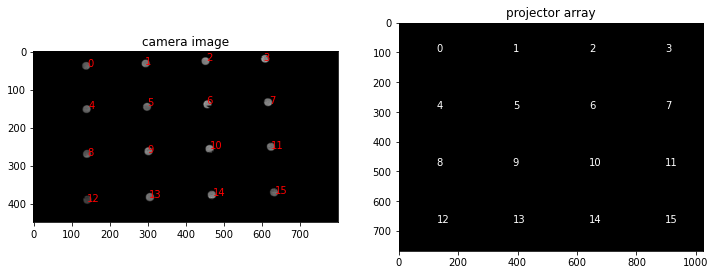

In [10]:
homo = get_homography_matrix()

In [21]:
img = np.load('calibration/num%d.npy'%1)

In [22]:
img.shape

(448, 800, 4)

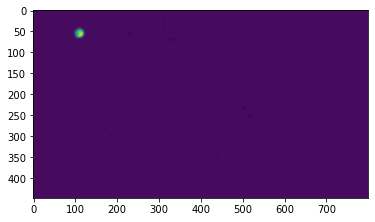

In [23]:
sigma = 7
homoG = cv2.GaussianBlur(homo, (sigma, sigma), cv2.BORDER_DEFAULT)
plt.imshow(homoG)

In [30]:
x, y = np.where(homoG == homoG.max())

In [32]:
x[0]

58

In [17]:
cv2.findContours(homo, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

error: OpenCV(3.4.2) C:\Miniconda3\conda-bld\opencv-suite_1534379934306\work\modules\imgproc\src\contours.cpp:199: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


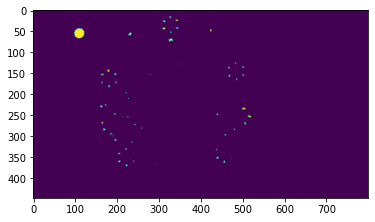

In [13]:
plt.imshow(b)

In [10]:
baseline = np.dot(np.load('calibration 2021.08.04/baseline.npy')[...,:3], rgb_weights)

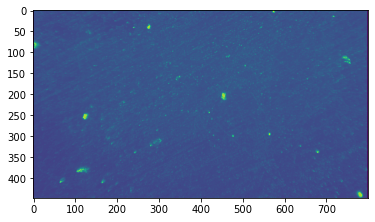

In [11]:
plt.imshow(baseline)

In [147]:
baseline = np.dot(np.load('calibration/baseline.npy')[...,:3], rgb_weights)
images = []
for i in range(0, calib_dots_dim**2+1):
    temp = np.load('calibration/num%d.npy'%i)
    images.append(np.dot(temp[...,:3], rgb_weights))

In [183]:
ni = 0

0


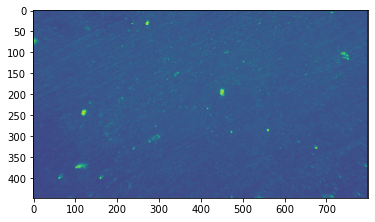

In [184]:
plt.imshow(images[ni])
print(ni)
ni += 1


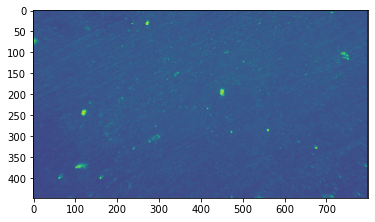

In [159]:
plt.imshow(baseline)

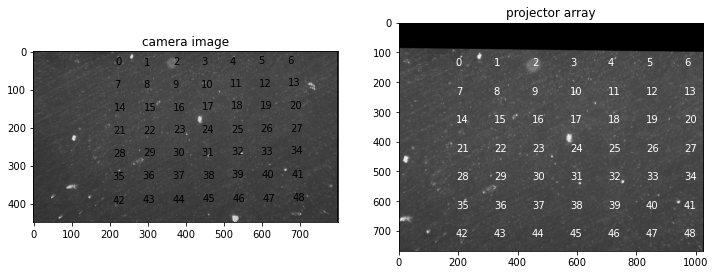

In [121]:
camera_draw = np.zeros((448, 800, 3), np.uint8)
camera_draw = cv2.circle(camera_draw, (300, 250), 50, (255, 255, 255), -1)
camera_draw = cv2.circle(camera_draw, (300, 250), 5, (255, 15, 15), -1)

im_out = cv2.warpPerspective(rnd_img, homo, (1024, 768))


fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title('camera image')
ax1.imshow(rnd_img, cmap = 'gray')
for i, crd in enumerate(coords_cam):
    ax1.text(crd[0], crd[1], str(i))

ax2.set_title('projector array')
ax2.imshow(im_out, cmap = 'gray')
for i, crd in enumerate(coords_prj):
    ax2.text(crd[0], crd[1], str(i), c = 'white')

# Calibration

In [119]:
baseline = np.dot(np.load('calibration/baseline.npy')[...,:3], rgb_weights)
images = []
for i in range(0, 65):
    temp = np.load('calibration/num%d.npy'%i)
    images.append(np.dot(temp[...,:3], rgb_weights))

In [92]:
coords_prj = []
coords_cam = []

for i in range(0, 65):
    img = np.load('calibration/num%d.npy'%i)
    img = np.dot(img[...,:3], rgb_weights)
    c = calib_get_postion(img-baseline)
    if c != -1:
        coords_cam.append(c)
        crds = num_to_coords(i, size = 8)
        coords_prj.append([crds[0], crds[1]])
    

In [93]:
projector_arr = np.zeros((768, 1024, 3), np.uint8)
sample_img = cv2.imread(wd + 'sample_img.jpg')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)

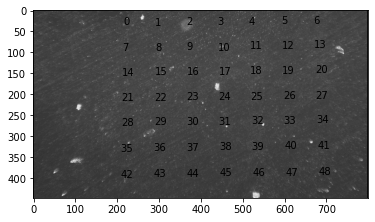

In [94]:
plt.imshow(images[11], cmap = 'gray')
for i, crd in enumerate(coords_cam):
    plt.text(crd[0], crd[1], str(i))

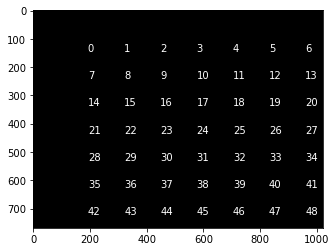

In [42]:
plt.imshow(projector_arr, cmap = 'gray')
for i, crd in enumerate(coords_prj):
    plt.text(crd[0], crd[1], str(i), c = 'white')

## Homography

In [62]:
coords_prj_arr = np.array(coords_prj)
coords_cam_arr = np.array(coords_cam)

tform = transform.estimate_transform('projective', coords_cam_arr, coords_prj_arr)
tf_img_warp = transform.warp(sample_img, tform.inverse, mode = 'edge')

In [69]:
h, status = cv2.findHomography(coords_cam_arr, coords_prj_arr)

In [70]:
im_out = cv2.warpPerspective(sample_img, h, (projector_arr.shape[1], projector_arr.shape[0]))

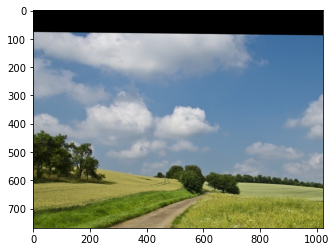

In [71]:
plt.imshow(im_out, cmap = 'gray')

In [76]:
sample_img.shape

(448, 800, 3)

In [72]:
camera_draw = np.zeros((600, 800, 1), np.uint8)

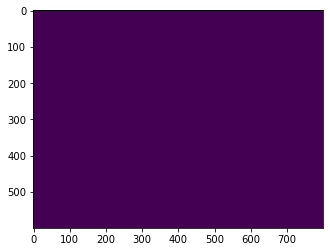

In [73]:

plt.imshow(camera_draw)

In [11]:
sample_img.shape

(448, 800, 3)

In [12]:
tf_img_warp = transform.warp(sample_img, tform, mode = 'edge')

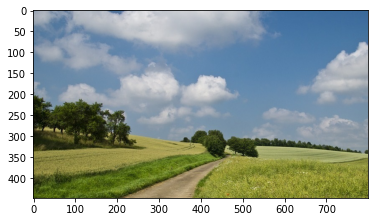

In [13]:
plt.imshow(sample_img, cmap = 'gray')

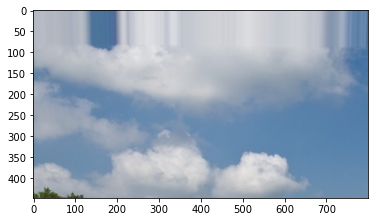

In [14]:
plt.imshow(tf_img_warp, cmap = 'gray')

In [15]:
points_of_interest = np.array(points_of_interest)
projection = np.array(projection)

tform = transform.estimate_transform('projective', points_of_interest, projection)
tf_img_warp = transform.warp(house, tform.inverse, mode = 'edge')
plt.figure(num=None, figsize=(8, 6), dpi=80)fig, ax = plt.subplots(1,2, figsize=(15, 10), dpi = 80)
ax[0].set_title(f'Original', fontsize = 15)
ax[0].imshow(house)
ax[0].set_axis_off();ax[1].set_title(f'Transformed', fontsize = 15)
ax[1].imshow(tf_img_warp)
ax[1].set_axis_off();

SyntaxError: invalid syntax (<ipython-input-15-47831376245e>, line 6)

## aaa

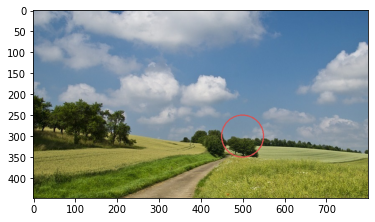

In [193]:
temp = cv2.circle(sample_img.copy(), (500, 300), 50, (220, 80, 80), 2)

plt.imshow(temp)

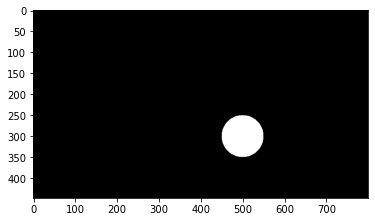

In [130]:
camera_draw = np.zeros((448, 800, 3), np.uint8)
camera_draw = cv2.circle(camera_draw, (500, 300), 50, (255, 255, 255), -1)
plt.imshow(camera_draw, cmap = 'gray')

In [129]:
kernel = np.ones((5, 5), np.uint8)
ckernel = np.asarray([
    [0,1,1,1,0],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [1,1,1,1,1],
    [0,1,1,1,0]
]).astype(np.uint8)

kernel2 = np.ones((2, 2), np.uint8)

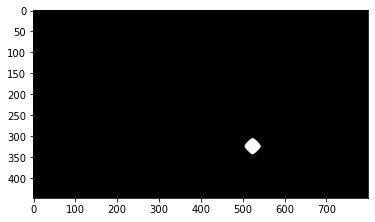

In [178]:
# Using cv2.erode() method 
camera_draw = cv2.erode(camera_draw, kernel2)
plt.imshow(camera_draw, cmap = 'gray')

In [128]:
cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

# Przydatne

## Przeklikalka kalibracyjna

In [352]:
for i in range(0, 65):
    img = np.load('temp/num%d.npy'%i)
    img = np.dot(img[...,:3], rgb_weights)
    c = calib_get_postion(baseline-img)
    if c != -1:
        coords_prj.append(c)
        coords_cam.append([num_to_coords(i, size = 8)])

In [353]:
ni = 0

27


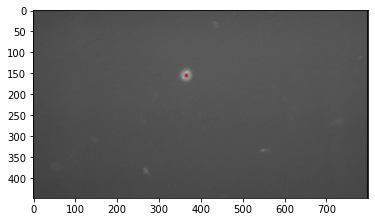

In [381]:
print(ni)
img = images[ni]
comp = img - baseline

c = calib_get_postion(img-baseline)
plt.imshow(img, cmap = 'gray')
if c != -1:
    plt.scatter(c[0], c[1], s = 4, c = 'red')
else:
    print('OUTSIDE')
    
ni += 1

# Misc

In [4]:
f = open('external_variables.txt', 'r')
cnt = f.read()
f.close()

cnt_dict = {}
cnt = cnt.split('\n')
for c in cnt:
    key, value = c.split(' = ')
    cnt_dict[key] = value

In [5]:
cnt_dict

{'elli_angle': '151', 'pulseOff': '2', 'pulseOn': '2'}

In [3]:
angle_to_absolute(90)

-211

In [13]:
projector_arr = np.zeros((768, 1024, 3), np.uint8)

In [20]:
num = 0

In [44]:
inc_x = int(1024/5)
inc_y = int(768/5)

In [70]:
def num_to_coords(num, size = 10, dim = (1024, 768)):    
    nx = int(num%size)
    ny = int((num-num%size)/size)
    
    inc_x = int(dim[0]/size)
    inc_y = int(dim[1]/size)
    
    x = int(inc_x/2) + nx*inc_x
    y = int(inc_y/2) + ny*inc_y
    
#     print('x = %d, y = %d'%(x, y))
    return x, y
    
    


In [71]:
for num in range(0, 25):
    num_to_coords(num, size = 5)

x = 102, y = 76
x = 306, y = 76
x = 510, y = 76
x = 714, y = 76
x = 918, y = 76
x = 102, y = 229
x = 306, y = 229
x = 510, y = 229
x = 714, y = 229
x = 918, y = 229
x = 102, y = 382
x = 306, y = 382
x = 510, y = 382
x = 714, y = 382
x = 918, y = 382
x = 102, y = 535
x = 306, y = 535
x = 510, y = 535
x = 714, y = 535
x = 918, y = 535
x = 102, y = 688
x = 306, y = 688
x = 510, y = 688
x = 714, y = 688
x = 918, y = 688


In [78]:
num = 0

x = 102, y = 76
0
x = 102, y = 76


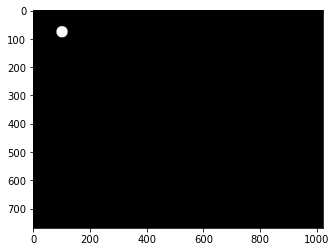

In [79]:
x, y = num_to_coords(num, size = 5)
    
projector_arr = np.zeros((768, 1024, 3), np.uint8)
projector_arr = cv2.circle(projector_arr, (x, y), 20, (255, 255, 255), -1)

plt.imshow(projector_arr)
print(num)
print('x = %d, y = %d'%(x, y))

num += 1